# Applied Data Science Capstone Week 4 #

## London boroughs and Neighbourhoods ##
## Finding a good site for an authentic, exotic, Restaurant ##
### Leveraging FourSquare ###

**By Edward de Ryckman**

https://github.com/eddyholland<br>edward.deryckman@mac.com

For the IBM / Coursera Data Science Capstone <br>
This ipython notebook is in experimental mode. <br>
All errors are mine. File any bug reports to /dev/null

Still - I hope you enjoy it

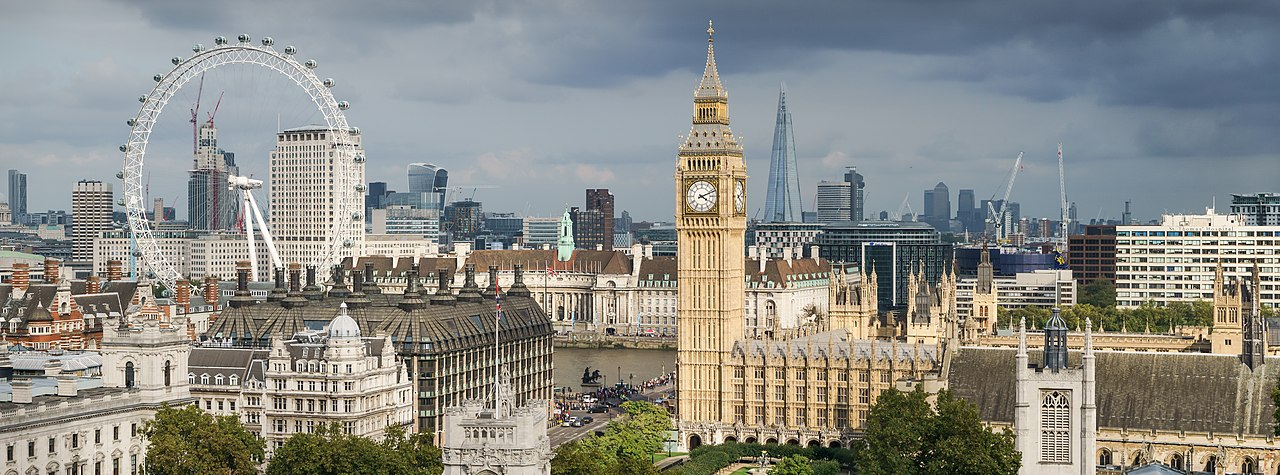

In [1]:
# Setup
!pip install bs4 beautifulsoup4
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import bs4
from bs4 import BeautifulSoup

**Outline / Structure**
1. Problem Statement - what is the Business Goal (business understanding)
2. Data Collection and Data Understanding
3. Data Preparation (data cleansing)
4. Modelling
5. Evaluation
6. Report
for feedback, I will rely on *your feedback* :-)

# 1. Problem Statement #

### Business Understanding ###

3 Friends - *Athos, Portos and Aramis* - came to me to seek advice on what would be a good **location** to open an exotic Restaurant in **London**

There are several key factors necessary (but not sufficient) for success in the Restaurant business. Among them are **location**, **supply vs demand** (competition) and **popularity or reputation** (create a buzz).

Our goal here is to find, extract, load and cleanse the data, that will help us to make a **recommendation** based on facts (data-driven decision) as to:
* The most promising location(s) in London
* The most promising *cuisines* to promote<br>
For the purposes of this exercise, *London* is defined as the London postcode district (not the greater metropolitan area that includes surrounding counties).

We will be making extensive use of data from **Four Square** supplemented by other open source data like Wikipedia, TFL, ODI, London datastore, etc. 


## 1.b Background ##

### London ###
The London postcodes is an area covering 241 square miles (excluding the surrounding county areas in the wider metropolitan area), broadly organized as 8 *Postcode Areas* and 120 postcodes (post outcodes). The inner (City of London / Westminster) are the central or downtown (CBD) area, known to Transport for London (TFL) az 'Zone 1' and the outer postcodes are residential districts (generally in Zone 3, 4 or 5). See https://en.wikipedia.org/wiki/London and https://en.wikipedia.org/wiki/London_postal_district

London itself is a very important global financial center with a vibrant economy and a large ethnic or immigrant population (including myself) and very well served by a broad and deep range of Restaurants and other leisure and nighlife venues. It is multi-culural and multi-lingual and still an important world city of 8M people (although larger metropolis exist elsewhere). I've lived in London 20+ years.

**Data Sources**
Postcodes we will be scraping from https://en.wikipedia.org/wiki/London_postal_district possibly other Open-source data sources. 
For tube (metro) locations we will be scraping from www.tfl.gov.uk

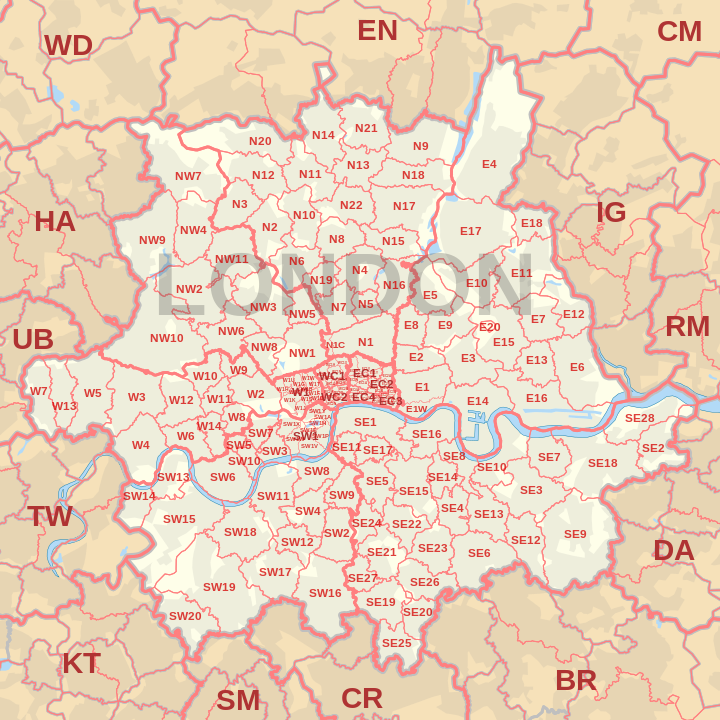

### Restaurant ###

**Supply vs. Demand** and Competition. 

Athos, Portos and Aramis each have their own recommendation for the foreign **cuisine** they want to open the Restaurant with - e.g. Cuban or Mexican, Lebanese, Polish. Personally I like all of them.

We will want to look at the:
1) Prevalance of Restaurants in London (and by borough) of different cuisines - because if the market is already saturated in, for example, Indian or French restaurants, we don't want to compete in that space.
2) Likely demand for under-served cuisines using for example population demographics (ethnic origin) or some other indicator of preference.

The goal being to identify a *Demand* that is *Underserved* in a given *Area* i.e. with little head-to-head competition with established Restaurants (of the same / similar cuisine) that aready have a reputation / popularity. If our cusine is *novel* to the area, we have a unique value proposition to attract new diners.

**Location, Location, Location**

When opening a Restaurant (and this is true of many customer-facing businesses) the geographical *Location* is key to success. This is why we will be using geo-location data, both of each London postcode, and of existing (competitor) Restaurants. Bear in mind that in real life it would not be only the centroids of postcodes (or their .geojson bounding boxes) that is of interest here, but the siting of the restaurant - is it on a busy street with lots of footfall, where it can be seen - and also is the frontage attractive (kerb appeal).

We will also try to cross-reference with TFL tube data - is it close to a tube, is there much traffic flow.

**Buzz**

To create a *Buzz* we will have to rely not only on the old-school physical promotion of the Restuaurant but also *Social Media* such as having recommendations on **Four Square** as well as Fessbouc and paying for keywords on Google searches in our London area. Also levearging Twitter, Instagram, etc. Of course if the cook is excellent then word-of-mouth is invaluable.

In [2]:
wiki_url = 'http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#note I nerfed from httpS to http to make this work and not throw errors.

Toronto_FSA_table = pd.read_html(wiki_url, flavor='html5lib')
#this returns a list of tables. We assume we want the first table.

Toronto_FSA_table[0].head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [3]:
#Get our first table [0] into our PD DataFrame
Toronto_FSA_df = Toronto_FSA_table[0]

# drop unwanted rows
Toronto_FSA_df = Toronto_FSA_df[Toronto_FSA_df.Borough != 'Not assigned']
Toronto_FSA_df = Toronto_FSA_df[Toronto_FSA_df.Borough != 'Mississauga'] ## Not in Toronto - Post Office depot - anomaly 

Toronto_FSA_df.head()

Postal Code           Borough                                Neighbourhood
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

Data Cleanup:

Check for any rows with a Borough name, but 'Not Assigned' in the neighbourhood, and copy the Borough to the Neighbourhood.
Check for any PostCodes (FSA) which appear more than once in the dataset, and combine those rows into 1 row (with a list of Neighbourhoods). This is to make the FSA code a unique key.

In [4]:
# Check for any Boroughs in the dataset, with 'Not assigned' in Neighbourhood
Toronto_FSA_df[Toronto_FSA_df.Neighbourhood == 'Not assigned']

Empty DataFrame
Columns: [Postal Code, Borough, Neighbourhood]
Index: []

In [5]:
Toronto_FSA_df.groupby(by='Postal Code').count().sort_values('Borough', ascending=False).head()

Borough  Neighbourhood
Postal Code                        
M1B                1              1
M5P                1              1
M6E                1              1
M6C                1              1
M6B                1              1

All **Good**, doesn't seem to be the case. I think someone cleaned up the Wikipage data before.

Because my index has missing index positions, let's reindex (to be tidy) and preview our data

Less *Mississauga*, we have 102 FSA codes, spanning 140 Neighbourhoods

In [6]:
Toronto_FSA_df = Toronto_FSA_df.reset_index().drop(columns=['index'])

In [7]:
Toronto_FSA_df.head()

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [8]:
Toronto_FSA_df.shape

(102, 3)

## Part 2 enrich our FSA dataframe with Lat, Long coordinates from Geocoder ##

Turns out this part will not work anymore (thanks geocoder) - skip a few lines till the new library pgeocode

In [9]:
!pip install geocoder
import geocoder

In [10]:
Toronto_FSA_df['Lat'] = None
Toronto_FSA_df['Long'] = None
still_work_todo = True
max_tries = 10

In [9]:
import time

In [12]:
i = 0
while still_work_todo and i < max_tries:
    for row in Toronto_FSA_df.itertuples():  
        time.sleep(0.01)
        g = geocoder.google('{}, Toronto, Ontario'.format(row[1]))
        try:
            row.Lat = g.latlng[0]
            row.Long = g.latlng[1]
            print('{}, {}, {}'.format(row[1], row.Lat, row.Long))
        except:
            # could be a None
            pass
    
    if Toronto_FSA_df['Lat'].isnull().sum() == 0:
        #success on all Latitudes - we can stop the while loop
        still_work_todo = False
        break
    
    else:
        i += 1
        print('.'* i)
        time.sleep(0.333) # recoil time (to cool off)
    
        

.
..
...
....
.....
......
.......
........
.........
..........


In [13]:
Toronto_FSA_df

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
97          M8X         Etobicoke   
98          M4Y  Downtown Toronto   
99          M7Y      East Toronto   
100         M8Y         Etobicoke   
101         M8Z         Etobicoke   

                                         Neighbourhood   Lat  Long  
0                                            Parkwoods  None  None  
1                                     Victoria Village  None  None  
2                            Regent Park, Harbourfront  None  None  
3                     Lawrence Manor, Lawrence Heights  None  None  
4          Queen's Park, Ontario Provincial Government  None  None  
..                                                 ...   ...   ...  
97       The Kingsway, Montgomery Road, Old Mill North  None  None  
98                                Church and Wellesley  None  None  
99   Business reply mail Processing Centre, South C...  None  None  
100  Old Mill South, King's Mill Park, Sunnylea, Hu...  None  None  
101  Mimico NW, The Queensway West, South of Bloor,...  None  None  

[102 rows x 5 columns]

In [14]:
Toronto_FSA_df['Lat'].isnull().sum()

102

In [15]:
Toronto_FSA_df = Toronto_FSA_df.drop(columns = ['Lat','Long'])

## Fail ##

Lesson: geocoder is not working anymore, it fails

**We Try Again**

**pgeocode FTW!**

In [10]:
!pip install pgeocode
import pgeocode

In [11]:
nomi = pgeocode.Nominatim('ca')
df = nomi.query_postal_code(Toronto_FSA_df.iloc[0,0])
print('{} : {}'.format(df['latitude'], df['longitude']))

43.7545 : -79.33


In [12]:
Toronto_FSA_df['Latitude'] = None
Toronto_FSA_df['Longitude'] = None
still_work_todo = True
max_tries = 3

In [13]:
i = 0

nomi = pgeocode.Nominatim('ca')

while still_work_todo and i < max_tries:
    
    for row in Toronto_FSA_df.itertuples():  
        time.sleep(0.01)
        df = nomi.query_postal_code(row[1])

        Toronto_FSA_df.at[row[0], 'Latitude'] = df['latitude']
        Toronto_FSA_df.at[row[0], 'Longitude'] = df['longitude']
        print('{} - {}, {}, {}'.format(row[0], row[1], df['latitude'], df['longitude']))
    
    if Toronto_FSA_df['Latitude'].isnull().sum() == 0:
        #success on all Latitudes - we can stop the while loop
        still_work_todo = False
    
    else:
        i += 1
        print('.'* i)
        time.sleep(0.25) # recoil time (to cool off)

0 - M3A, 43.7545, -79.33
1 - M4A, 43.7276, -79.3148
2 - M5A, 43.6555, -79.3626
3 - M6A, 43.7223, -79.4504
4 - M7A, 43.6641, -79.3889
5 - M9A, 43.6662, -79.5282
6 - M1B, 43.8113, -79.193
7 - M3B, 43.745, -79.359
8 - M4B, 43.7063, -79.3094
9 - M5B, 43.6572, -79.3783
10 - M6B, 43.7081, -79.4479
11 - M9B, 43.6505, -79.5517
12 - M1C, 43.7878, -79.1564
13 - M3C, 43.7334, -79.3329
14 - M4C, 43.6913, -79.3116
15 - M5C, 43.6513, -79.3756
16 - M6C, 43.6915, -79.4307
17 - M9C, 43.6437, -79.5767
18 - M1E, 43.7678, -79.1866
19 - M4E, 43.6784, -79.2941
20 - M5E, 43.6456, -79.3754
21 - M6E, 43.6889, -79.4507
22 - M1G, 43.7712, -79.2144
23 - M4G, 43.7124, -79.3644
24 - M5G, 43.6564, -79.38600000000002
25 - M6G, 43.6683, -79.4205
26 - M1H, 43.7686, -79.2389
27 - M2H, 43.8015, -79.3577
28 - M3H, 43.7535, -79.4472
29 - M4H, 43.7059, -79.3464
30 - M5H, 43.6496, -79.3833
31 - M6H, 43.6655, -79.4378
32 - M1J, 43.7464, -79.2323
33 - M2J, 43.7801, -79.3479
34 - M3J, 43.7694, -79.4921
35 - M4J, 43.6872, -79.33

In [14]:
Toronto_FSA_df.head(5)

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

  Latitude Longitude  
0  43.7545    -79.33  
1  43.7276  -79.3148  
2  43.6555  -79.3626  
3  43.7223  -79.4504  
4  43.6641  -79.3889

In [15]:
Toronto_FSA_df.describe()

Postal Code     Borough Neighbourhood  Latitude  Longitude
count          102         102           102  102.0000   102.0000
unique         102          10            98   98.0000    97.0000
top            M4G  North York     Downsview   43.7334   -79.3823
freq             1          24             4    2.0000     3.0000

## Part 3: Segmentation and Clustering using Foursquare and KNN ##

In [16]:
import folium
import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

### First let's Map Toronto neighbourhoods ###

In [17]:
map_TO = folium.Map(location=[43.7124, -79.3644], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_FSA_df['Latitude'], Toronto_FSA_df['Longitude'], Toronto_FSA_df['Borough'], Toronto_FSA_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_TO)  
    
map_TO

#### Define Foursquare Credentials and Version


In [18]:
CLIENT_ID = 'AB5AMGTIZ3MP3WS1EZPNW2XYO3G4ACCWZOZEHUWK4SSRXJH4' # my Foursquare ID
CLIENT_SECRET = 'U2A4KZRTK4D5H2H42KKDYILDFERZLHOTC4AWWNR4RC5UPSSS' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

My credentails:
CLIENT_ID: AB5AMGTIZ3MP3WS1EZPNW2XYO3G4ACCWZOZEHUWK4SSRXJH4


In [19]:
RADIUS=500
#I checked and 500m should be sufficient span for Toronto, but they are circular bubbles (there will be gaps uptown, but overlaps downtown)
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

#### This function we learned from the labs, it fetches a list of nearby venues from Foursquare.
#### I will need to call this for each of my 102 Toronto, O. neighbourhoods


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
TO_venues = getNearbyVenues(names= Toronto_FSA_df['Neighbourhood'],
                                   latitudes= Toronto_FSA_df['Latitude'],
                                   longitudes= Toronto_FSA_df['Longitude'])
print(TO_venues.shape)
TO_venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods                43.7545                -79.3300   
1         Parkwoods                43.7545                -79.3300   
2         Parkwoods                43.7545                -79.3300   
3  Victoria Village                43.7276                -79.3148   
4  Victoria Village                43.7276                -79.3148   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1             649 Variety       43.754513       -79.331942   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1      Convenience Store  
2      Food & Drink Shop  
3           Hockey Arena  
4  Portuguese Restaurant

In [22]:
print(TO_venues.shape)
TO_venues.head()

(2136, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods                43.7545                -79.3300   
1         Parkwoods                43.7545                -79.3300   
2         Parkwoods                43.7545                -79.3300   
3  Victoria Village                43.7276                -79.3148   
4  Victoria Village                43.7276                -79.3148   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1             649 Variety       43.754513       -79.331942   
2           Variety Store       43.751974       -79.333114   
3  Victoria Village Arena       43.723481       -79.315635   
4               Portugril       43.725819       -79.312785   

          Venue Category  
0                   Park  
1      Convenience Store  
2      Food & Drink Shop  
3           Hockey Arena  
4  Portuguese Restaurant

Let's check how many venues were returned for each neighborhood


In [23]:
TO_venues.groupby('Neighborhood').count().sort_values('Venue', ascending=False).head(10)

Neighborhood Latitude  \
Neighborhood                                                      
Richmond, Adelaide, King                                    100   
Commerce Court, Victoria Hotel                              100   
Toronto Dominion Centre, Design Exchange                    100   
Garden District, Ryerson                                    100   
First Canadian Place, Underground city                      100   
Stn A PO Boxes                                               99   
Berczy Park                                                  93   
St. James Town                                               88   
Church and Wellesley                                         76   
Lawrence Manor, Lawrence Heights                             71   

                                          Neighborhood Longitude  Venue  \
Neighborhood                                                              
Richmond, Adelaide, King                                     100    100   
Commerce Court, Victoria Hotel                               100    100   
Toronto Dominion Centre, Design Exchange                     100    100   
Garden District, Ryerson                                     100    100   
First Canadian Place, Underground city                       100    100   
Stn A PO Boxes                                                99     99   
Berczy Park                                                   93     93   
St. James Town                                                88     88   
Church and Wellesley                                          76     76   
Lawrence Manor, Lawrence Heights                              71     71   

                                          Venue Latitude  Venue Longitude  \
Neighborhood                                                                
Richmond, Adelaide, King                             100              100   
Commerce Court, Victoria Hotel                       100              100   
Toronto Dominion Centre, Design Exchange             100              100   
Garden District, Ryerson                             100              100   
First Canadian Place, Underground city               100              100   
Stn A PO Boxes                                        99               99   
Berczy Park                                           93               93   
St. James Town                                        88               88   
Church and Wellesley                                  76               76   
Lawrence Manor, Lawrence Heights                      71               71   

                                          Venue Category  
Neighborhood                                              
Richmond, Adelaide, King                             100  
Commerce Court, Victoria Hotel                       100  
Toronto Dominion Centre, Design Exchange             100  
Garden District, Ryerson                             100  
First Canadian Place, Underground city               100  
Stn A PO Boxes                                        99  
Berczy Park                                           93  
St. James Town                                        88  
Church and Wellesley                                  76  
Lawrence Manor, Lawrence Heights                      71

In [24]:
print('There are {} uniques categories.'.format(len(TO_venues['Venue Category'].unique())))

There are 255 uniques categories.


#### Most common or most popular type of Venue:

In [25]:
TO_venues.groupby('Venue Category').count().sort_values('Venue', ascending=False).head(10)

Neighborhood  Neighborhood Latitude  \
Venue Category                                             
Coffee Shop                   171                    171   
Café                           89                     89   
Restaurant                     67                     67   
Pizza Place                    53                     53   
Park                           49                     49   
Bakery                         49                     49   
Hotel                          45                     45   
Italian Restaurant             44                     44   
Japanese Restaurant            44                     44   
Sandwich Place                 41                     41   

                     Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                       
Coffee Shop                             171    171             171   
Café                                     89     89              89   
Restaurant                               67     67              67   
Pizza Place                              53     53              53   
Park                                     49     49              49   
Bakery                                   49     49              49   
Hotel                                    45     45              45   
Italian Restaurant                       44     44              44   
Japanese Restaurant                      44     44              44   
Sandwich Place                           41     41              41   

                     Venue Longitude  
Venue Category                        
Coffee Shop                      171  
Café                              89  
Restaurant                        67  
Pizza Place                       53  
Park                              49  
Bakery                            49  
Hotel                             45  
Italian Restaurant                44  
Japanese Restaurant               44  
Sandwich Place                    41

## More analysis of Neighbourhoods 


In [26]:
# one hot encoding
TO_venues_oh = pd.get_dummies(TO_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
TO_venues_oh['Neighborhood'] = TO_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [TO_venues_oh.columns[-1]] + list(TO_venues_oh.columns[:-1])
TO_venues_oh = TO_venues_oh[fixed_columns]

TO_venues_oh.head()

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  Airport  \
0            0                  0               0                  0        0   
1            0                  0               0                  0        0   
2            0                  0               0                  0        0   
3            0                  0               0                  0        0   
4            0                  0               0                  0        0   

   American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                    0            0           0                    0   
1                    0            0           0                    0   
2                    0            0           0                    0   
3                    0            0           0                    0   
4                    0            0           0                    0   

   Asian Restaurant  ...  Vegetarian / Vegan Restaurant  Video Game Store  \
0                 0  ...                              0                 0   
1                 0  ...                              0                 0   
2                 0  ...                              0                 0   
3                 0  ...                              0                 0   
4                 0  ...                              0                 0   

   Video Store  Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  \
0            0                      0                0           0         0   
1            0                      0                0           0         0   
2            0                      0                0           0         0   
3            0                      0                0           0         0   
4            0                      0                0           0         0   

   Wine Shop  Wings Joint  Women's Store  
0          0            0              0  
1          0            0              0  
2          0            0              0  
3          0            0              0  
4          0            0              0  

[5 rows x 255 columns]

In [27]:
TO_venues_oh.shape

(2136, 255)

#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [28]:
TO_venues_agg = TO_venues_oh.groupby('Neighborhood').mean().reset_index()
TO_venues_agg.head(10)

Neighborhood  Yoga Studio  \
0                                          Agincourt     0.000000   
1                             Alderwood, Long Branch     0.000000   
2    Bathurst Manor, Wilson Heights, Downsview North     0.000000   
3                                    Bayview Village     0.000000   
4                  Bedford Park, Lawrence Manor East     0.000000   
5                                        Berczy Park     0.010753   
6                        Birch Cliff, Cliffside West     0.000000   
7       Brockton, Parkdale Village, Exhibition Place     0.000000   
8  Business reply mail Processing Centre, South C...     0.071429   
9  CN Tower, King and Spadina, Railway Lands, Har...     0.017241   

   Accessories Store  Adult Boutique  Afghan Restaurant  Airport  \
0           0.000000             0.0                0.0      0.0   
1           0.000000             0.0                0.0      0.0   
2           0.000000             0.0                0.0      0.0   
3           0.000000             0.0                0.0      0.0   
4           0.000000             0.0                0.0      0.0   
5           0.000000             0.0                0.0      0.0   
6           0.000000             0.0                0.0      0.0   
7           0.025641             0.0                0.0      0.0   
8           0.000000             0.0                0.0      0.0   
9           0.000000             0.0                0.0      0.0   

   American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  ...  \
0             0.000000     0.000000         0.0             0.000000  ...   
1             0.000000     0.000000         0.0             0.000000  ...   
2             0.000000     0.000000         0.0             0.000000  ...   
3             0.000000     0.000000         0.0             0.000000  ...   
4             0.043478     0.000000         0.0             0.000000  ...   
5             0.000000     0.021505         0.0             0.000000  ...   
6             0.000000     0.000000         0.0             0.000000  ...   
7             0.000000     0.025641         0.0             0.025641  ...   
8             0.000000     0.000000         0.0             0.000000  ...   
9             0.000000     0.000000         0.0             0.000000  ...   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                       0.000000               0.0          0.0   
1                       0.000000               0.0          0.0   
2                       0.000000               0.0          0.0   
3                       0.000000               0.0          0.0   
4                       0.000000               0.0          0.0   
5                       0.010753               0.0          0.0   
6                       0.000000               0.0          0.0   
7                       0.000000               0.0          0.0   
8                       0.000000               0.0          0.0   
9                       0.000000               0.0          0.0   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0                    0.0              0.0         0.0       0.0        0.0   
1                    0.0              0.0         0.0       0.0        0.0   
2                    0.0              0.0         0.0       0.0        0.0   
3                    0.0              0.0         0.0       0.0        0.0   
4                    0.0              0.0         0.0       0.0        0.0   
5                    0.0              0.0         0.0       0.0        0.0   
6                    0.0              0.0         0.0       0.0        0.0   
7                    0.0              0.0         0.0       0.0        0.0   
8                    0.0              0.0         0.0       0.0        0.0   
9                    0.0              0.0         0.0       0.0        0.0   

   Wings Joint  Women's Store  
0     0.000000            0.0  
1     0.000000        

In [29]:
TO_venues_agg.shape

(96, 255)

Interestingly only 96 neighbourhoods returned **any** venues at all from Foursquare. Some 100, some very few.

## Cluster Neighborhoods using KNN clusering


Run _k_-means to cluster the neighborhood.

I will try various values of K, like 4, 5, 6, 7, 8, 10

But I won't go into details here about K-Folds or how to pick the best K


In [30]:
# set number of clusters
kclusters = 7

TO_venues_agg_clustering = TO_venues_agg.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TO_venues_agg_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nhoods_venues_sorted = pd.DataFrame(columns=columns)
nhoods_venues_sorted['Neighborhood'] = TO_venues_agg['Neighborhood']

for ind in np.arange(TO_venues_agg.shape[0]):
    nhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TO_venues_agg.iloc[ind, :], num_top_venues)

nhoods_venues_sorted.shape

(96, 11)

In [34]:
nhoods_venues_sorted[0:4]

Neighborhood     1st Most Common Venue  \
0                                        Agincourt            Breakfast Spot   
1                           Alderwood, Long Branch         Convenience Store   
2  Bathurst Manor, Wilson Heights, Downsview North  Mediterranean Restaurant   
3                                  Bayview Village               Flower Shop   

       2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0               Skating Rink  Latin American Restaurant       Badminton Court   
1                Pizza Place                Coffee Shop        Sandwich Place   
2  Middle Eastern Restaurant                Coffee Shop   Fried Chicken Joint   
3                Gas Station                       Park    Golf Driving Range   

  5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
0           Fish Market     Fish & Chips Shop                  Flea Market   
1                   Pub                   Gym            Electronics Store   
2         Deli / Bodega         Grocery Store                  Pizza Place   
3                 Trail  Ethiopian Restaurant  Eastern European Restaurant   

  8th Most Common Venue        9th Most Common Venue  \
0                 Field  Eastern European Restaurant   
1            Donut Shop          Dumpling Restaurant   
2        Farmers Market           Falafel Restaurant   
3     Electronics Store                  Escape Room   

        10th Most Common Venue  
0               Farmers Market  
1  Eastern European Restaurant  
2                  Event Space  
3                  Event Space

In [42]:
# add clustering labels
nhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged_df = Toronto_FSA_df

In [44]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged_df = Toronto_merged_df.join(nhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged_df.head() # KNN Cluster labels, and with top 10 venue categories.

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

  Latitude Longitude  Cluster Labels 1st Most Common Venue  \
0  43.7545    -79.33             3.0     Food & Drink Shop   
1  43.7276  -79.3148             1.0          Hockey Arena   
2  43.6555  -79.3626             1.0           Coffee Shop   
3  43.7223  -79.4504             1.0        Clothing Store   
4  43.6641  -79.3889             1.0    Italian Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Park     Convenience Store              Creperie   
1           Pizza Place                  Park           Coffee Shop   
2        Breakfast Spot            Restaurant           Yoga Studio   
3           Coffee Shop         Women's Store            Restaurant   
4      Sushi Restaurant              Creperie       Bubble Tea Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0    Dumpling Restaurant           Flea Market           Fish Market   
1  Portuguese Restaurant          Intersection     French Restaurant   
2                 Bakery            Beer Store                   Spa   
3       Toy / Game Store      Sushi Restaurant        Cosmetics Shop   
4                   Café    Mexican Restaurant    Chinese Restaurant   

  8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
0     Fish & Chips Shop                 Field         Fast Food Restaurant  
1  Ethiopian Restaurant   Dumpling Restaurant  Eastern European Restaurant  
2                   Pub   Distribution Center                      Theater  
3                Bakery           Men's Store               Sandwich Place  
4           Escape Room              Beer Bar             Ramen Restaurant

In [57]:
#Toronto_merged_df = Toronto_merged_df[Toronto_merged_df['Cluster Labels'].notnull()] 
Toronto_merged_df['Cluster Labels'] = Toronto_merged_df['Cluster Labels'].fillna(value='7')
# for NaN put mystery cluster '7'
Toronto_merged_df['Cluster Labels'] = Toronto_merged_df['Cluster Labels'].apply(np.int64)
#Cheap trick (sorry) to drop the few NAN clusters and make float clusters corrected as integer.


In [61]:
# create map
map_clusters = folium.Map(location=[43.7124, -79.3644], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_df['Latitude'], Toronto_merged_df['Longitude'], Toronto_merged_df['Neighbourhood'], Toronto_merged_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Synthesis

Here we have Clustered the 102 Toronto, On. neighbourhoods by reference to **FourSquare** API calls to explore
the centroid of the neighbourhood, and log the most frequent categories of **venues**

The Reader should note some shortcuts or limitations.

For this exercise, any venue within 500M of the postal code centroid, would pick up the matching venues (first 100 only). 
A better way would be to find a datasource with .geojson bounding boxes of the neighbourhoods. There are some neighbourhoods which are larger than a 500M radius circle. There are others, where a 500M radius circle overlaps several tightly packed neighborhoods. Also, some neighbourhoods returned few venues (some zero - these were updated to arbirary new cluster 7, you can see a few in orange). 
But this is perhaps good enough for a first attempt, for week 3. I hope to do better in final project (with .geojson bounding boxes). 

For KNN, we tried 5, 9 and 7.  I settled on 7 but I won't dwell too much on measuring the accuracy.